# HSE nlp project. EDA. Dmitriy Lyalin

# Оглавление
1. [Провести анализ текстов: расчет средней, минимальной и максимальной длины текстов (визуализация распределения)](#section1)
2. [Частотный анализ слов и n-грамм, извлечение биграмм и триграмм](#section2)
3. [Статистики по символам и словам, распределение частей речи](#section3)
4. [Изучение связи текстовых признаков с целевой переменной](#section4)
5. [Визуализация данных: облако наиболее частотных слов и биграмм для выявления ключевых тем (Word Clouds)](#section5)
6. [Визуализация данных: методы снижения размерности (например, t-SNE) для визуализации текстовых представлений](#section6)
7. [Первичная предобработка текста: оценка и обработка пропусков, дубликатов; очистка текста от шумовых данных (ненужные символы, HTML-теги, специальные символы)](#section7)
8. [Вывод о структуре данных, их особенностях и потенциальных проблемах на основе разведочного анализа данных](#section8)
9. [Другие формы разведочного анализа данных и интересные визуализации](#section9)

Дисклеймер. Текст в датасете уже частично был предобработан Виталием, спасибо ему за это!

**Импорт необходимых библиотек**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from nltk import FreqDist
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import random
import re

**Посмотрим на наши данные**

In [2]:
data = pd.read_parquet('/kaggle/input/hse-nlp-eda-dataset')

In [3]:
data.shape

(101, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   author          101 non-null    object
 1   author_surname  101 non-null    object
 2   title           101 non-null    object
 3   text            101 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


In [5]:
data.head()

,author,author_surname,title,text
0,Alexandre_Dumas,Dumas,Celebrated_Crimes_Complete,"CELEBRATED CRIMES, COMPLETE BY ALEXANDRE DUMAS..."
1,Victor_Hugo,Hugo,Les_Misérables,LES MISÉRABLES By Victor Hugo Translated by I...
2,Lev_Tolstoy,Tolstoy,War_And_Peace,WAR AND PEACE By Leo Tolstoy/Tolstoi Contents...
3,Guy_De_Maupassant,Maupassant,Original_Short_Stories,GUY DE MAUPASSANT ORIGINAL SHORT STORIES VOLUM...
4,Miguel_De_Cervantes_Saavedra,Saavedra,Don_Quixote,bookcover.jpg Full Size spine.jpg (152K) Full...


#### <a id="section1"></a> 1. Проведем анализ текстов: расчет средней, минимальной и максимальной длины текстов (визуализация распределения)

In [6]:
data['text_length'] = data['text'].apply(len)
mean_length = data['text_length'].mean()
min_length = data['text_length'].min()
max_length = data['text_length'].max()
print(f"Средняя длина текста: {mean_length}")
print(f"Минимальная длина текста: {min_length}")
print(f"Максимальная длина текста: {max_length}")

Средняя длина текста: 734419.6336633663
Минимальная длина текста: 10892
Максимальная длина текста: 3512831


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


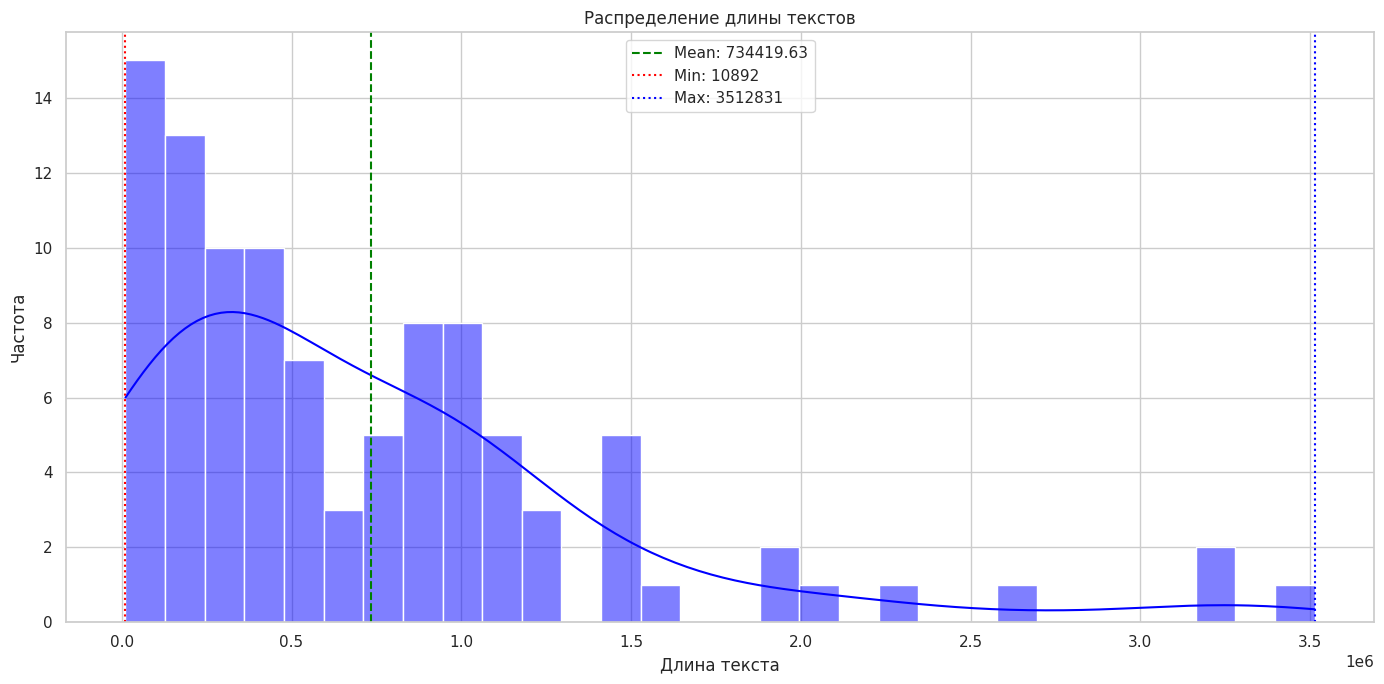

In [7]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
sns.histplot(data['text_length'], bins=30, kde=True, color='blue')

plt.axvline(mean_length, color='green', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(min_length, color='red', linestyle=':', label=f'Min: {min_length}')
plt.axvline(max_length, color='blue', linestyle=':', label=f'Max: {max_length}')

plt.title('Распределение длины текстов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

#### <a id="section2"></a> 2. Частотный анализ слов и n-грамм, извлечение биграмм и триграмм

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_and_clean(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

def get_top_ngrams(corpus, n=1, top_k=10):
    all_ngrams = []
    for text in corpus:
        tokens = tokenize_and_clean(text)
        n_grams = list(ngrams(tokens, n))
        all_ngrams.extend(n_grams)
    
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_k)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
top_unigrams = get_top_ngrams(data['text'], n=1, top_k=10)
top_bigrams = get_top_ngrams(data['text'], n=2, top_k=10)
top_trigrams = get_top_ngrams(data['text'], n=3, top_k=10)

In [10]:
def plot_top_ngrams_seaborn(ngrams, title):
    ngrams_df = pd.DataFrame(ngrams, columns=['ngram', 'count'])
    ngrams_df['ngram'] = ngrams_df['ngram'].apply(lambda x: ' '.join(x))
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=ngrams_df, x='ngram', y='count')
    plt.title(title)
    plt.xlabel('N-грамма')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

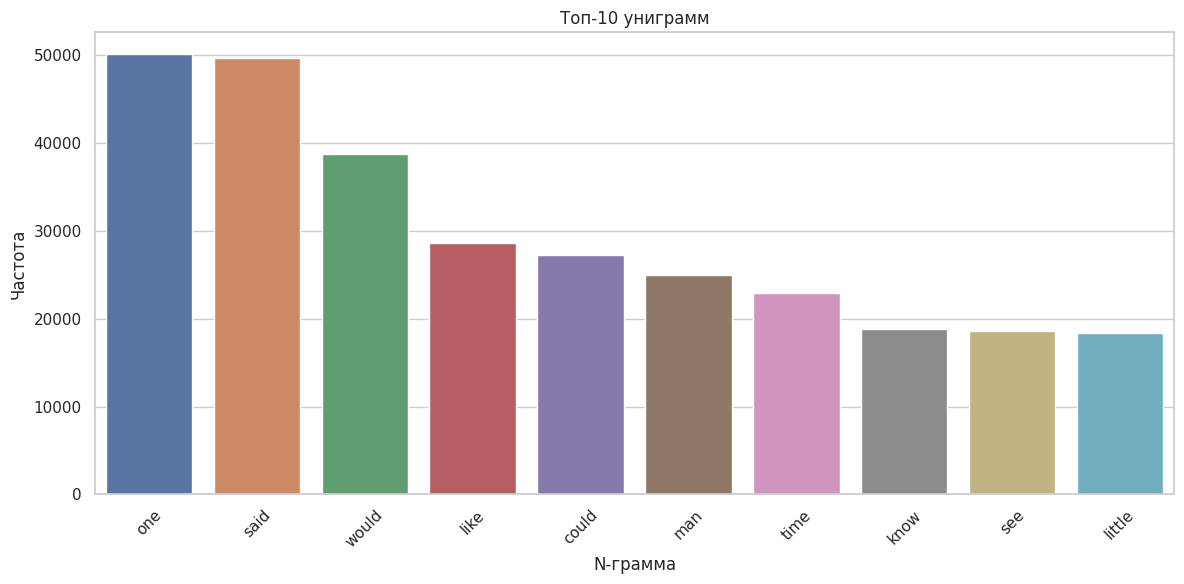

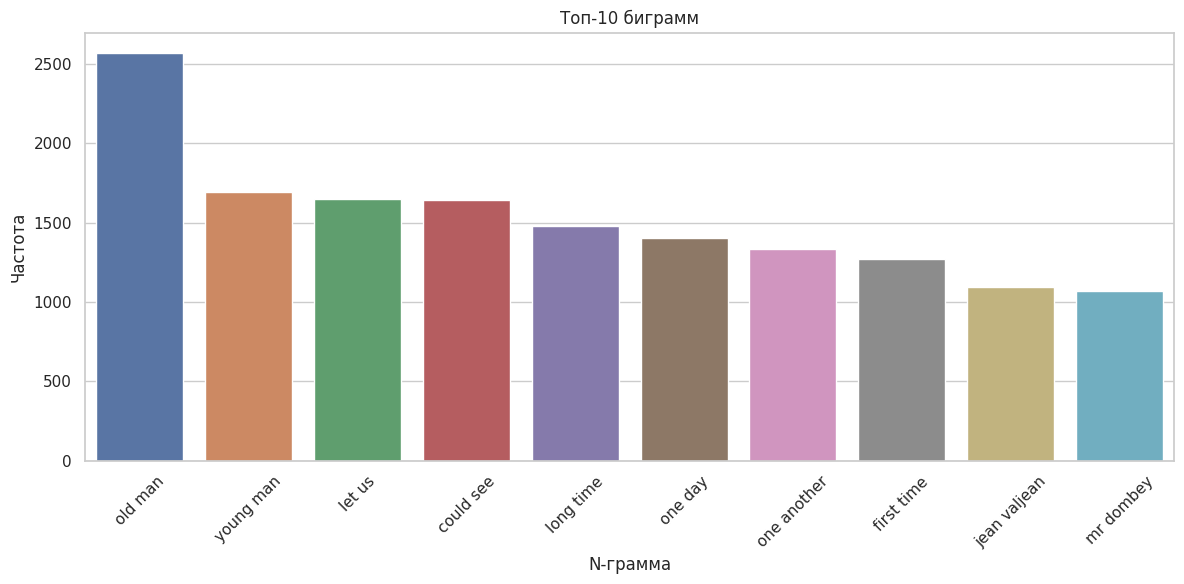

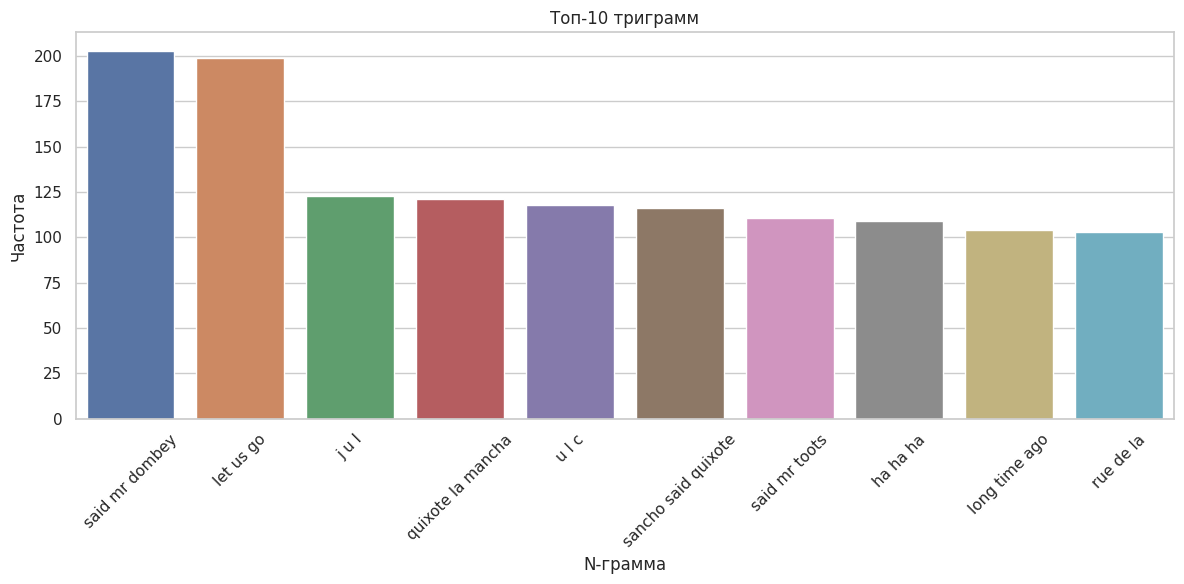

In [11]:
plot_top_ngrams_seaborn(top_unigrams, 'Топ-10 униграмм')
plot_top_ngrams_seaborn(top_bigrams, 'Топ-10 биграмм')
plot_top_ngrams_seaborn(top_trigrams, 'Топ-10 триграмм')

#### <a id="section3"></a> 3. Статистики по символам и словам, распределение частей речи

In [12]:
nlp = spacy.load('en_core_web_sm')

def get_text_statistics(corpus):
    num_chars = [len(text) for text in corpus]
    num_words = [len(text.split()) for text in corpus]
    return num_chars, num_words

num_chars, num_words = get_text_statistics(data['text'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


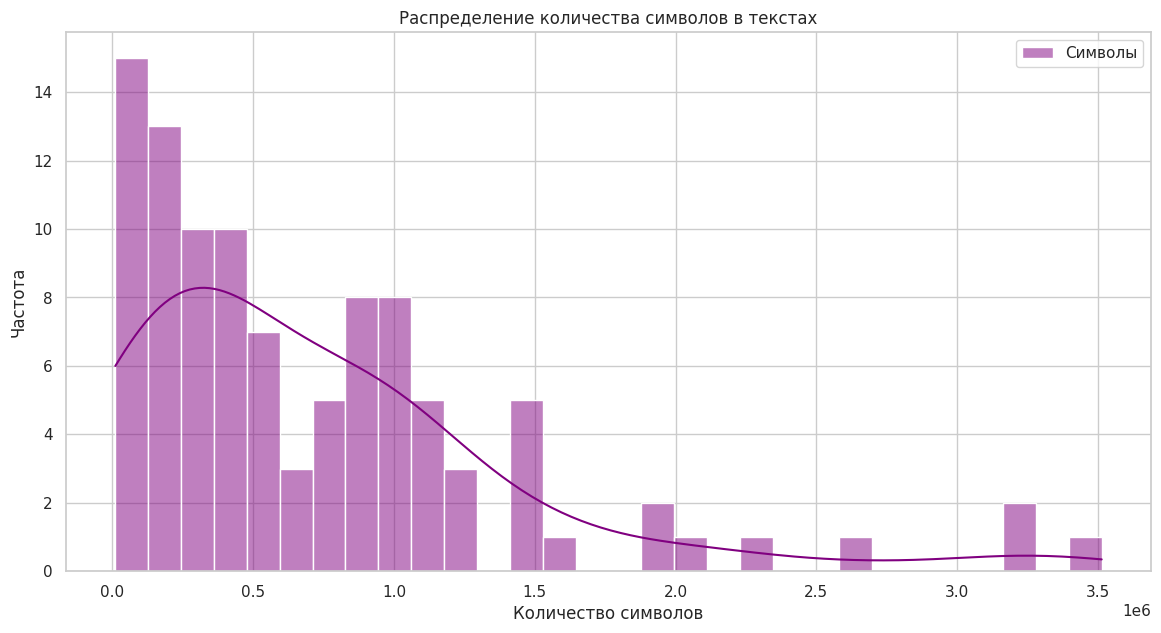

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


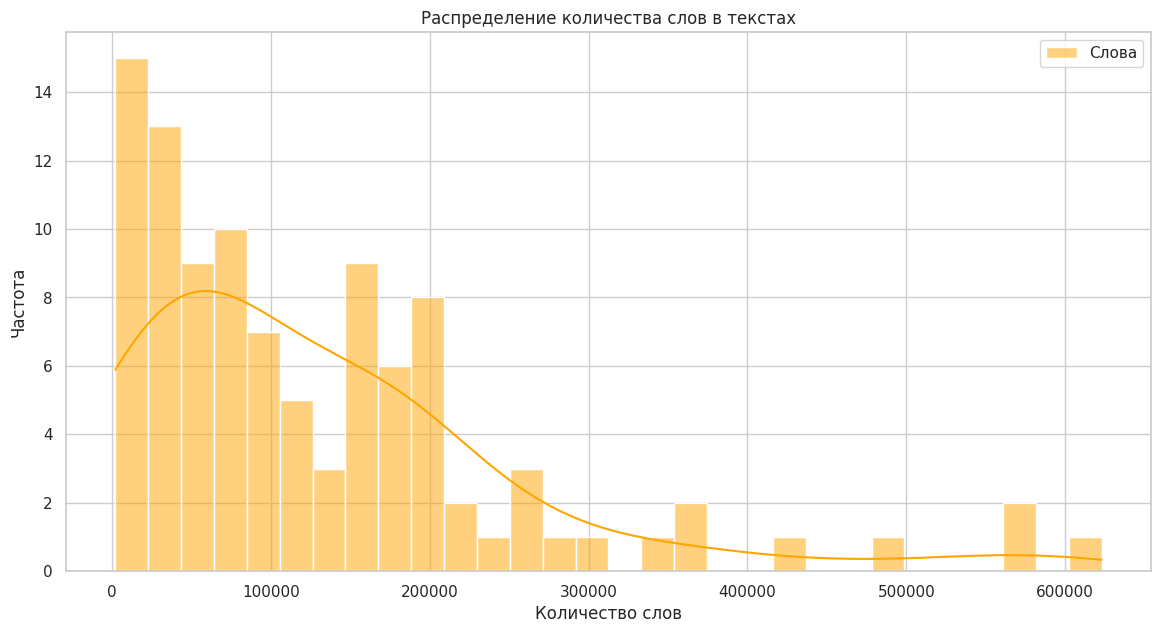

In [13]:
plt.figure(figsize=(14, 7))
sns.histplot(num_chars, bins=30, kde=True, color='purple', label='Символы')
plt.title('Распределение количества символов в текстах')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
sns.histplot(num_words, bins=30, kde=True, color='orange', label='Слова')
plt.title('Распределение количества слов в текстах')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.legend()
plt.show()

Далее мне не хватило 30гб оперативки. Так что отберем тексты покороче

In [14]:
max_length_threshold = 300000
filtered_texts = data[data['text'].apply(len) <= max_length_threshold]['text']

In [15]:
filtered_texts.shape

(34,)

In [16]:
pos_counts = Counter()
for text in filtered_texts:
    doc = nlp(text)
    pos_counts.update([token.pos_ for token in doc])

In [17]:
pos_df = pd.DataFrame(pos_counts.items(), columns=['POS', 'Count'])
pos_df.head()

,POS,Count
0,NOUN,172594
1,NUM,7202
2,PRON,127682
3,AUX,54117
4,VERB,124263


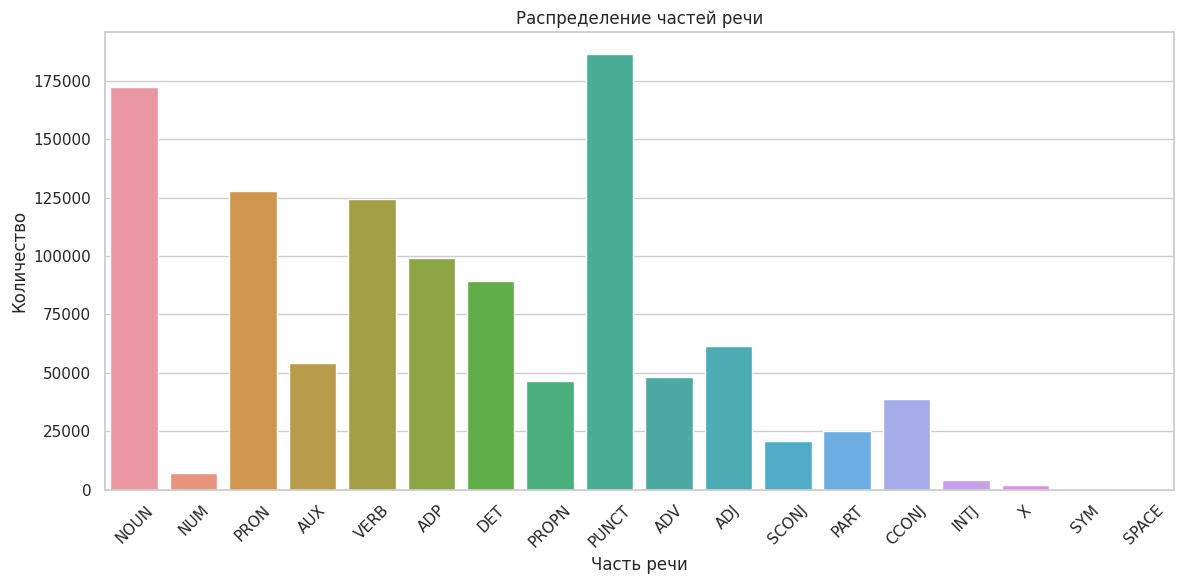

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(data=pos_df, x='POS', y='Count')
plt.title('Распределение частей речи')
plt.xlabel('Часть речи')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### <a id="section4"></a> 4. Изучение связи текстовых признаков с целевой переменной

**Лексическое разнообразие**

In [19]:
data['lexical_diversity'] = data['text'].apply(lambda x: len(set(x.split())) / len(x.split()))

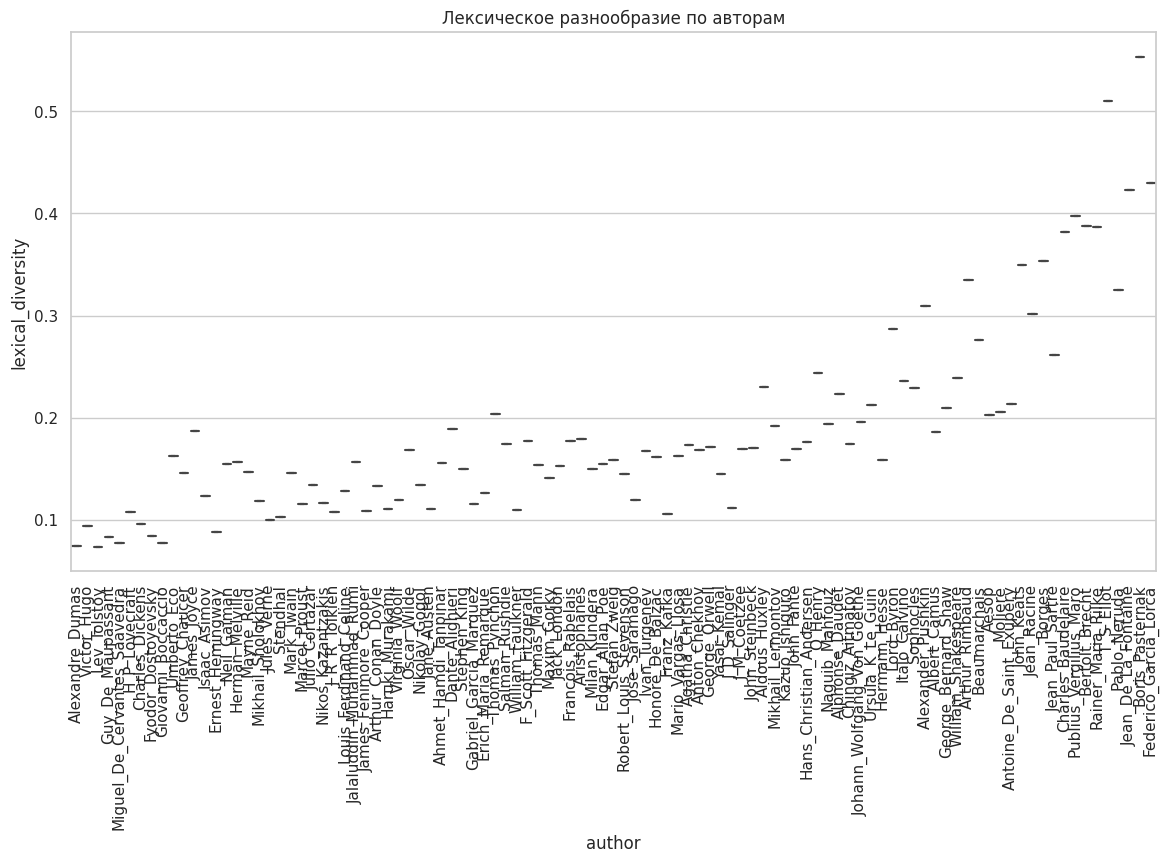

In [20]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=data, x='author', y='lexical_diversity')
plt.title('Лексическое разнообразие по авторам')
plt.xticks(rotation=90)
plt.show()

**Частотный анализ частей речи**

In [21]:
def pos_analysis(data):
    pos_counts = {}
    for author in data['author'].unique():
        author_texts = data[data['author'] == author]['text']
        combined_text = ' '.join(author_texts)
        doc = nlp(combined_text)
        pos_counts[author] = Counter([token.pos_ for token in doc])
    return pos_counts

In [22]:
max_length_threshold = 300000
filtered_texts = data[data['text'].apply(len) <= max_length_threshold]

In [23]:
pos_counts = pos_analysis(filtered_texts)

In [24]:
pos_counts['John_Fante']

Counter({'PUNCT': 11408,
         'PRON': 10300,
         'NOUN': 9945,
         'VERB': 8578,
         'ADP': 6071,
         'DET': 5466,
         'ADJ': 3397,
         'AUX': 3240,
         'ADV': 2759,
         'CCONJ': 2667,
         'PROPN': 2347,
         'PART': 1346,
         'SCONJ': 980,
         'NUM': 610,
         'INTJ': 222,
         'X': 2,
         'SYM': 2})

In [25]:
pos_df = pd.DataFrame(pos_counts).fillna(0).astype(int)
pos_df = pos_df.transpose()
pos_df.index.name = 'Author'

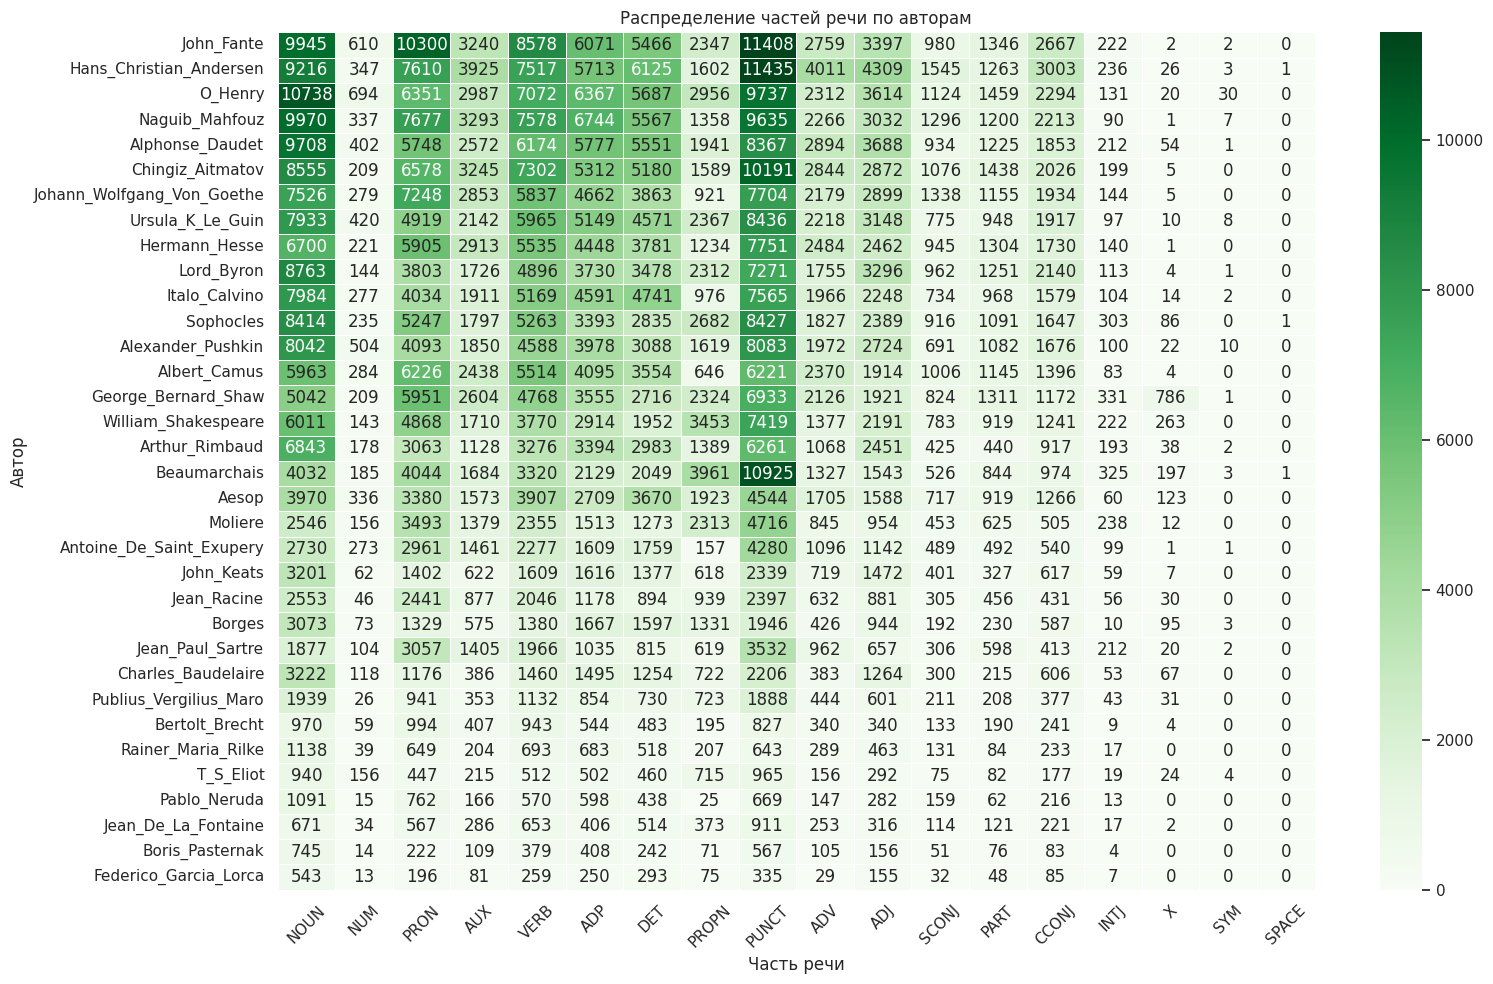

In [26]:
plt.figure(figsize=(16, 10))
sns.heatmap(pos_df, annot=True, fmt='d', cmap='Greens', linewidths=0.5)
plt.title('Распределение частей речи по авторам')
plt.xlabel('Часть речи')
plt.ylabel('Автор')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**TF-IDF анализ**

In [27]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
data['tfidf_keywords'] = tfidf_df.idxmax(axis=1)

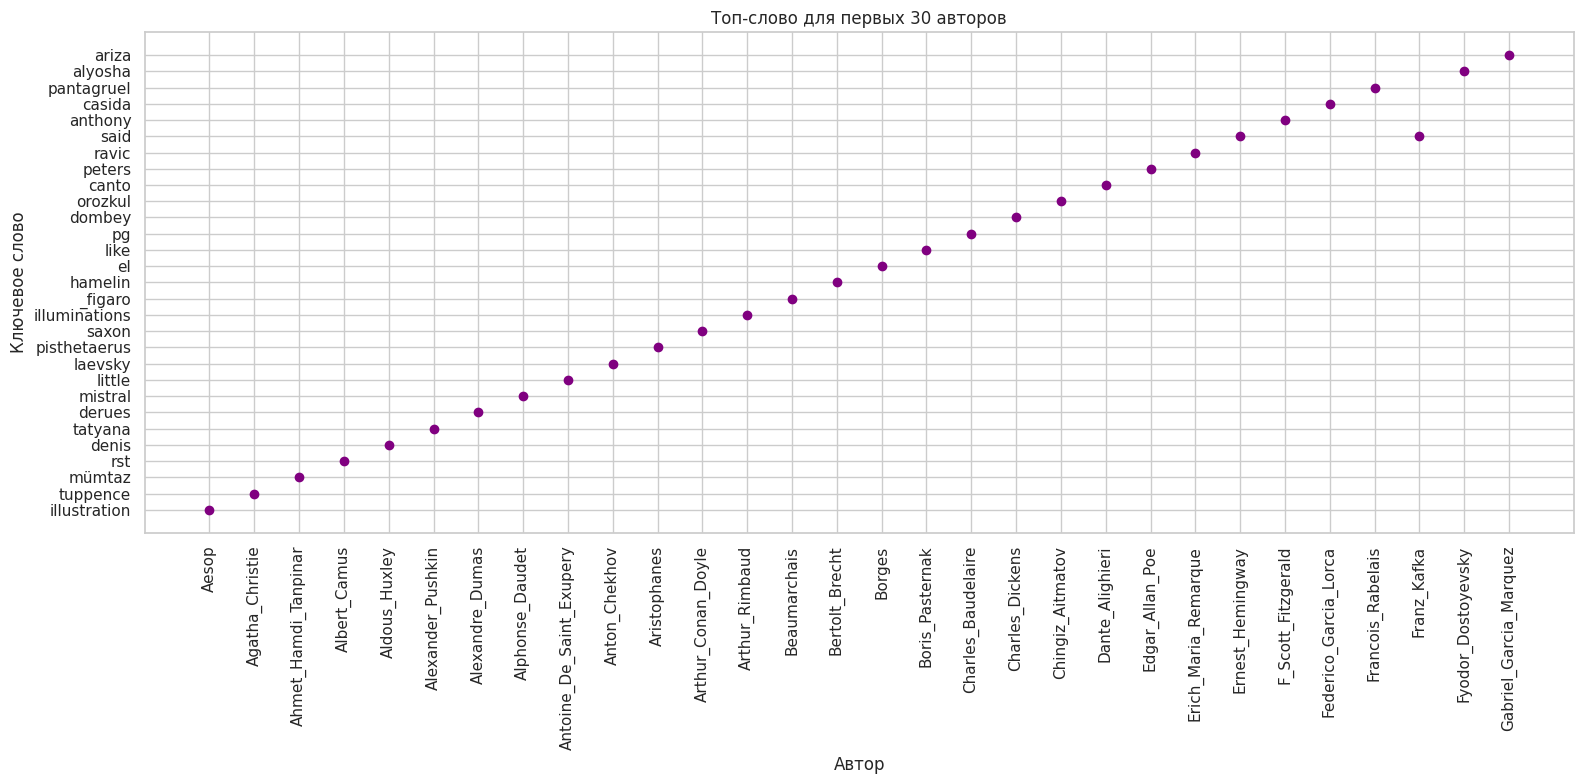

In [28]:
top_word_per_author = data.groupby('author')['tfidf_keywords'].first().reset_index()

top_word_per_author = top_word_per_author.head(30)

plt.figure(figsize=(16, 8))
plt.scatter(top_word_per_author['author'], top_word_per_author['tfidf_keywords'], color='purple')
plt.title('Топ-слово для первых 30 авторов')
plt.xlabel('Автор')
plt.ylabel('Ключевое слово')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### <a id="section5"></a> 5. Визуализация данных: облако наиболее частотных слов и биграмм для выявления ключевых тем (Word Clouds)

In [29]:
all_text = ' '.join(data['text'].tolist()).lower()

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    max_words=100,
    colormap='viridis'
).generate(all_text)

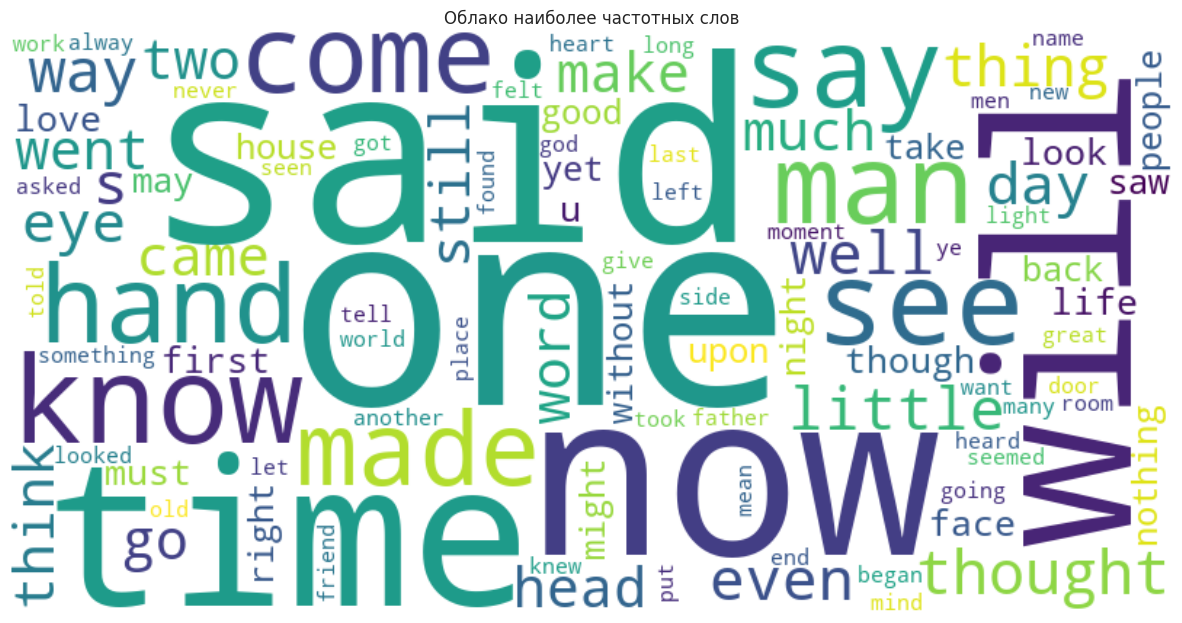

In [30]:
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако наиболее частотных слов')
plt.show()

#### <a id="section6"></a> 6. Визуализация данных: методы снижения размерности (например, t-SNE) для визуализации текстовых представлений

In [31]:
authors_subset = data['author'].unique()[:20]
filtered_data = data[data['author'].isin(authors_subset)]

tfidf = TfidfVectorizer(stop_words='english', max_features=500)
tfidf_matrix = tfidf.fit_transform(filtered_data['text'])

tsne_model = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=1000)
tsne_results = tsne_model.fit_transform(tfidf_matrix.toarray())

/tmp/ipykernel_1246/577410270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['tsne_1'] = tsne_results[:, 0]
/tmp/ipykernel_1246/577410270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['tsne_2'] = tsne_results[:, 1]


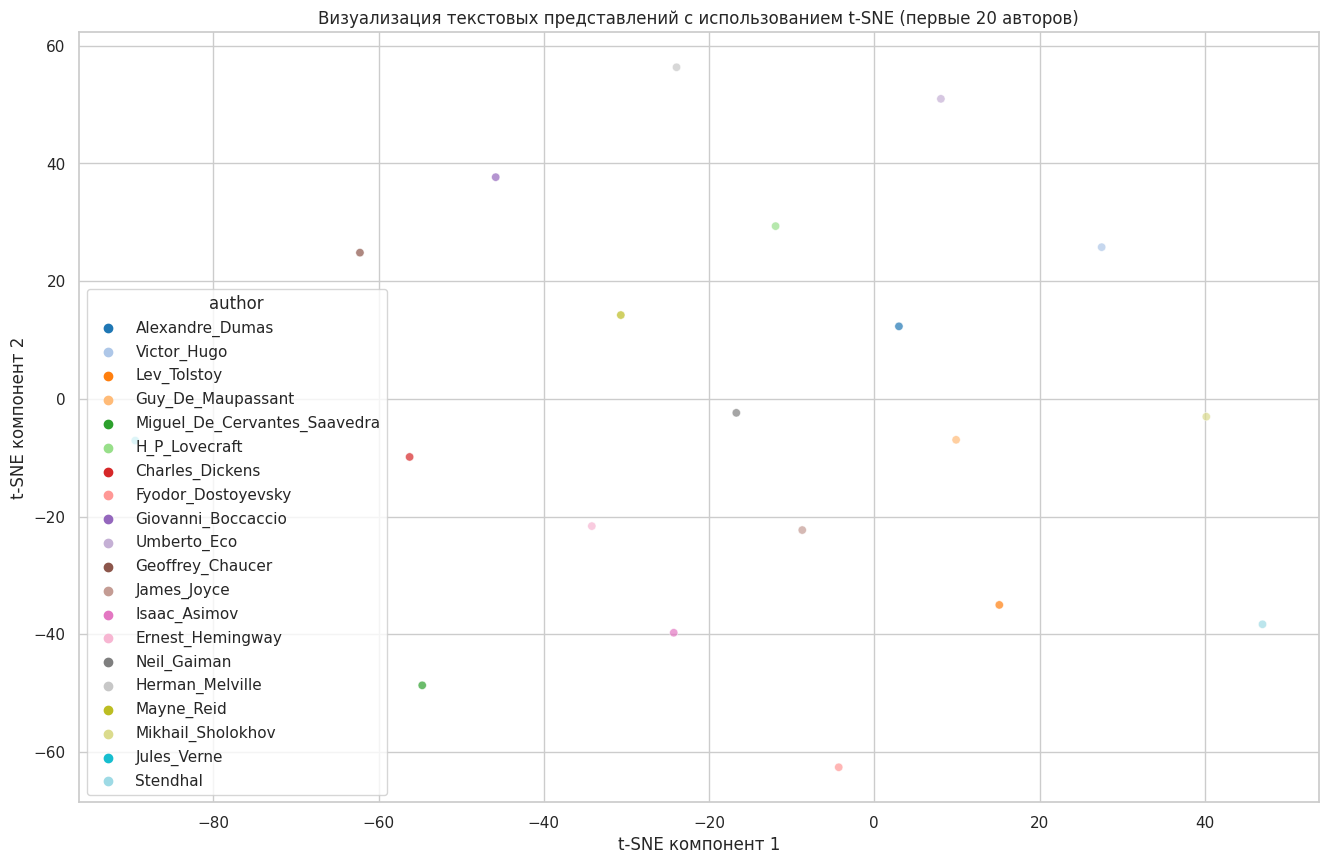

In [32]:
filtered_data['tsne_1'] = tsne_results[:, 0]
filtered_data['tsne_2'] = tsne_results[:, 1]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='author',
    palette='tab20',
    data=filtered_data,
    legend='full',
    alpha=0.7
)
plt.title('Визуализация текстовых представлений с использованием t-SNE (первые 20 авторов)')
plt.xlabel('t-SNE компонент 1')
plt.ylabel('t-SNE компонент 2')
plt.show()

#### <a id="section7"></a> 7. Первичная предобработка текста: оценка и обработка пропусков, дубликатов; очистка текста от шумовых данных (ненужные символы, HTML-теги, специальные символы)

Посмотрим, все ли вычистил Виталий

In [33]:
data.isnull().sum()

author               0
author_surname       0
title                0
text                 0
text_length          0
lexical_diversity    0
tfidf_keywords       0
dtype: int64

In [34]:
data.duplicated().sum()

0

In [35]:
data.author_surname.duplicated().sum()

0

In [36]:
def contains_html(text):
    return bool(re.search(r'<[^>]+>', text))

data['has_html'] = data['text'].apply(contains_html)
html_count = data['has_html'].sum()
print(f"\nКоличество текстов с HTML-тегами: {html_count}")

def contains_special_chars(text):
    return bool(re.search(r'[^a-zA-Z0-9\s]', text))

data['has_special_chars'] = data['text'].apply(contains_special_chars)
special_chars_count = data['has_special_chars'].sum()
print(f"\nКоличество текстов со специальными символами: {special_chars_count}")


Количество текстов с HTML-тегами: 7

Количество текстов со специальными символами: 101


#### <a id="section8"></a> 8. Вывод о структуре данных, их особенностях и потенциальных проблемах на основе разведочного анализа данных

* Разная длина текстов между авторами.
* Выделенные ключевые слова и n-граммы помогают различать стили авторов.
* Распределение частей речи указывает на различия в стилях.
* Html теги и спецсимволы необходимо дополнительно обработать
* Возможно, потребуется разбиение на части длинных текстов для эффективной работы будущей модели классификации.

#### <a id="section9"></a> 9. Другие формы разведочного анализа данных и интересные визуализации

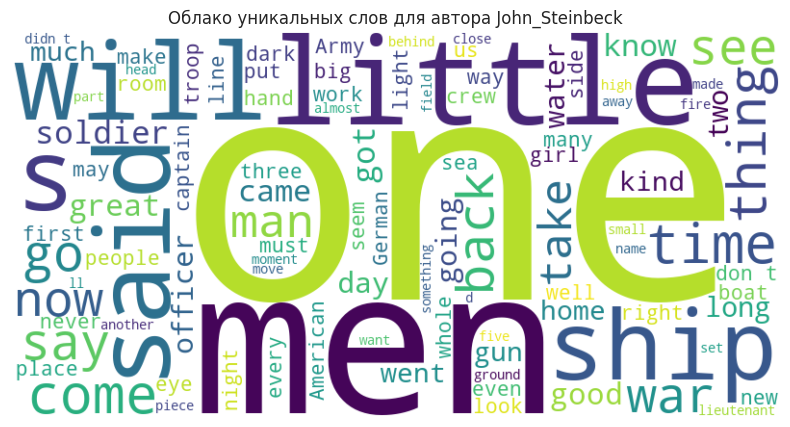

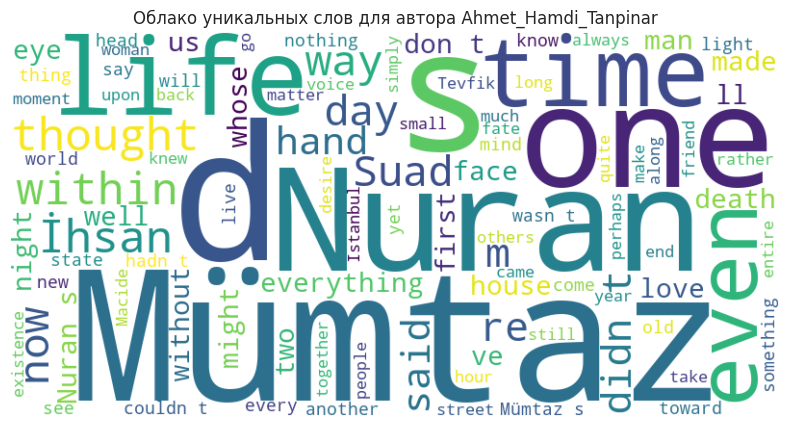

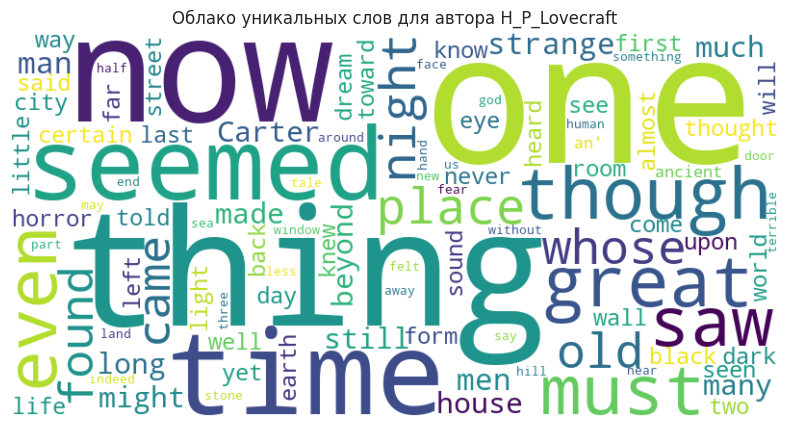

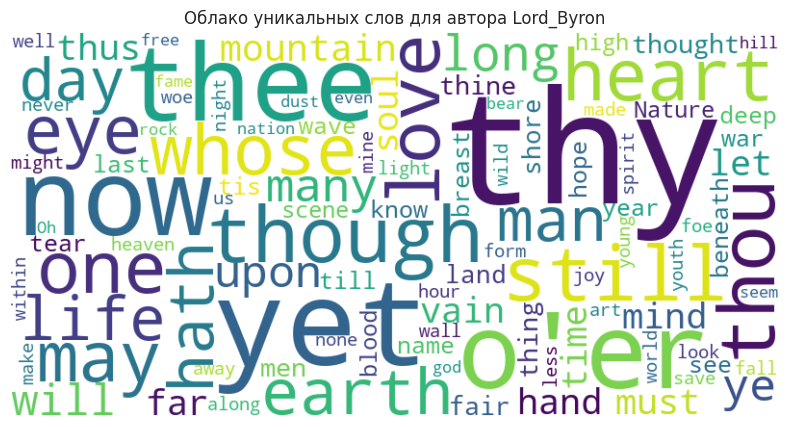

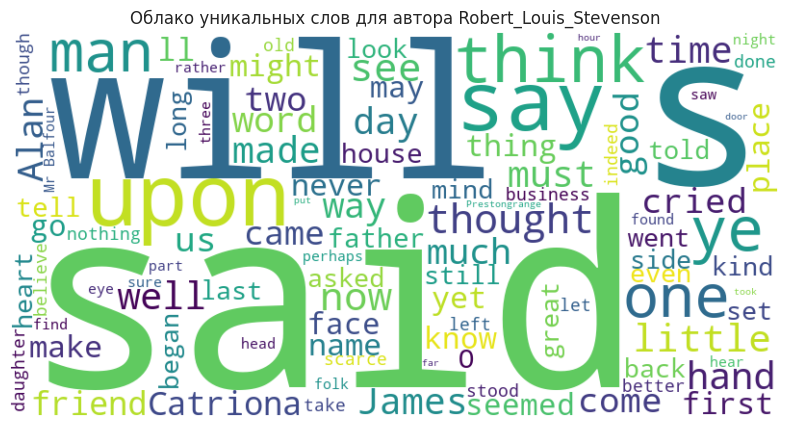

In [37]:
authors = data['author'].unique()

random_authors = random.sample(list(authors), 5)

for author in random_authors:
    author_text = ' '.join(data[data['author'] == author]['text'])
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        max_words=100,
        colormap='viridis'
    ).generate(author_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако уникальных слов для автора {author}')
    plt.show()